# Modelling


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
import warnings
# filter warnings
warnings.filterwarnings('ignore')

#### Prepare datasets

In [2]:
# Load the inward remittance flows dataset
df = pd.read_csv('/content/remittance_inflows.csv', index_col = 0)

print(df.shape)
# Display the first few rows of the dataset
df.head()

(171, 34)


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,%GDP_2022
Migrant remittance inflows (US$ million),,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,253.367822,348.624717,627.710802,822.731630,803.546454,828.571904,788.917115,300.000000,350.000000,2.058824
Albania,0.00000,0.000000,151.8,332.000000,307.100000,427.3,550.900000,300.300000,504.140000,407.200000,...,1421.007454,1290.863508,1306.009167,1311.822432,1458.210056,1472.812242,1465.987212,1718.320554,1800.000000,9.859772
Algeria,352.44176,232.990263,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,2452.442617,1997.393458,1989.023597,1791.887073,1984.998399,1785.838683,1699.608935,1759.095247,1829.459057,0.977510
Angola,0.00000,0.000000,0.0,0.000000,0.000000,0.0,5.142000,0.000000,0.000000,0.000000,...,30.971119,11.114712,3.988048,1.418196,1.579247,3.445473,8.053051,12.631149,16.420494,0.013158
Antigua and Barbuda,9.40000,0.000000,0.0,7.925926,8.614815,0.0,8.940741,9.537037,18.755556,18.394444,...,32.100000,31.244412,26.705676,24.020044,32.768265,36.955426,36.331448,50.142028,34.590023,2.044328


In [3]:
inflow = df.copy()

##Modelling

In [4]:
# Split the data into input and target variables
X = inflow.drop(columns=['%GDP_2022'], axis=1) # Features
y = inflow['%GDP_2022'] # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the input data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Train shape:', X_train.shape) 
print('Test shape:', X_test.shape)

Train shape: (136, 33)
Test shape: (35, 33)


## Define functions for the models and train on the normalized data

### Linear Regression Model

In [5]:
# Linear regression model
def linear_regression_model(X_trian, y_train, X_test, y_test):
    # Train a linear regression model on the normalized data
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Evaluate the model performance on the testing set
    y_pred = lr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # print(f'Mean Squared Error: {mse}')
    # print(f'R^2 Score: {r2}')
    return mae, mse, rmse

### Random Forest Model

In [6]:
# Random Forest model
def random_forest_model(X_train, y_train, X_test, y_test):
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

### XGBoost Model

In [7]:
def xgboost_model(X_train, y_train, X_test, y_test):
    # Train an XGBoost model on the normalized data
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
    xgb_model = xgb.train(params, dtrain, num_boost_round=100)

    # Evaluate the model performance on the testing set
    y_pred = xgb_model.predict(dtest)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return mae, mse, rmse

### Ridge Regression Model

In [8]:
# Ridge regression
def ridge_regression(X_train, y_train, X_test, y_test):
    # Train a ridge regression model on the normalized data
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)

    # Evaluate the model performance on the testing set
    y_pred = ridge.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return mae, mse, rmse

### Lasso Regression Model

In [9]:
# Lasso Regression
def lasso_regression(X_train, y_train, X_test, y_test):
    # Train a ridge regression model on the normalized data
    lasso = Lasso(alpha=1.0)
    lasso.fit(X_train, y_train)

    # Evaluate the model performance on the testing set
    y_pred = lasso.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return mae, mse, rmse

### SVR Model

In [10]:
# SVR model function
def svr_model(X_train, y_train, X_test, y_test):
    # Train an SVR model on the normalized data
    svr = SVR(kernel='rbf', C=1.0, gamma='scale')
    svr.fit(X_train, y_train)

    # Evaluate the model performance on the testing set
    y_pred = svr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return mae, mse, rmse

### SGD model

In [11]:
from sklearn.linear_model import SGDRegressor
def sgd_model(X_train, y_train, X_test, y_test):
    # Train an SVR model on the normalized data
    sgd_model = SGDRegressor(max_iter=1000, tol=1e-3)
    sgd_model.fit(X_train, y_train)

    # Evaluate the model performance on the testing set
    y_pred = sgd_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return mae, mse, rmse

## Evaluating the performance metrics of the models

In [12]:
# Call the linear regression model function
lr_mae, lr_mse, lr_rmse = linear_regression_model(X_train, y_train, X_test, y_test)

# Call the random forest model function
rf_mae, rf_mse, rf_rmse = random_forest_model(X_train, y_train, X_test, y_test)

# Call the XGBoost model function
xgb_mae, xgb_mse, xgb_rmse = xgboost_model(X_train, y_train, X_test, y_test)

# Call the Ridge model function
ridge_mae, ridge_mse, ridge_rmse = ridge_regression(X_train, y_train, X_test, y_test)
                                             
# Call the Lasso model function
lasso_mae, lasso_mse, lasso_rmse = lasso_regression(X_train, y_train, X_test, y_test)

# Call the SVR model function
svr_mae, svr_mse, svr_rmse = svr_model(X_train, y_train, X_test, y_test)

# Call the SGD model function
sgd_mae, sgd_mse, sgd_rmse = sgd_model(X_train, y_train, X_test, y_test)

In [13]:
# Create a dictionary with the evaluation metrics for each model
metrics = {
    'Linear Regression': [lr_mae, lr_mse, lr_rmse],
    'Random Forest': [rf_mae, rf_mse, rf_rmse],
    'XGBoost': [xgb_mae, xgb_mse, xgb_rmse],
    'Ridge': [ridge_mae, ridge_mse, ridge_rmse],
    'Lasso': [lasso_mae, lasso_mse, lasso_rmse],
    'SVR': [svr_mae, svr_mse, svr_rmse],
    'SGD': [sgd_mae, sgd_mse, sgd_rmse]
}

# Create a pandas dataframe from the dictionary
df_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=['MAE', 'MSE', 'RMSE'])

# Print the dataframe
df_metrics

,MAE,MSE,RMSE
Linear Regression,5.892203,61.148973,7.819781
Random Forest,4.818888,48.982562,6.998754
XGBoost,5.306699,60.191991,7.758350
Ridge,5.253557,45.058726,6.712580
Lasso,5.507718,47.603492,6.899528
SVR,3.817812,51.180846,7.154079
SGD,5.326554,45.030583,6.710483


Based on the output, the **Random Forest** model has the lowest MAE, MSE, and RMSE values, indicating that it has the best performance among the models listed. The SVR model also has relatively low values for all three metrics, indicating good performance as well. However, it's important to note that the choice of metric depends on the specific problem being solved, and other factors such as interpretability and computational complexity should also be considered when selecting a model.

## HYPERPARAMETER TUNING USING GridSearchCV

In [14]:
# Create instances of the models
rf = RandomForestRegressor()
svr = SVR()

In [15]:
# Define the parameter grid for Randon forest model
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
# Perform grid search on random forest model
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)

In [ ]:
# Define the parameter grid for SVR model
svr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 'auto']
}

In [ ]:
# Perform grid search
svr_grid_search = GridSearchCV(svr, svr_param_grid, cv=5)
svr_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1.0, 10.0], 'epsilon': [0.01, 0.1, 1],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [19]:
# Print the best hyperparameters and score for each model
print('Random Forest:')
print('Best Parameters:', rf_grid_search.best_params_)
print('Best Score:', rf_grid_search.best_score_)
print('====='* 6)

print('SVR:')
print('Best Parameters:', svr_grid_search.best_params_)
print('Best Score:', svr_grid_search.best_score_)
print('====='* 6)

Random Forest:
Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: -0.00831592137594792
SVR:
Best Parameters: {'C': 10.0, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score: -0.11301899236324098


### LSTM model

In [20]:
inflow = df.copy()

In [21]:
# Split the data into training and testing sets
train_data = inflow.iloc[:len(inflow)-12, :]
test_data = inflow.iloc[len(inflow)-12:, :]

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [22]:
# Reshape the data to have a third dimension of size 1
X_train = np.reshape(train_data[:, :-1], (train_data.shape[0], 1, train_data.shape[1]-1))
y_train = train_data[:, -1]
X_test = np.reshape(test_data[:, :-1], (test_data.shape[0], 1, test_data.shape[1]-1))
y_test = test_data[:, -1]

In [23]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, verbose=0)

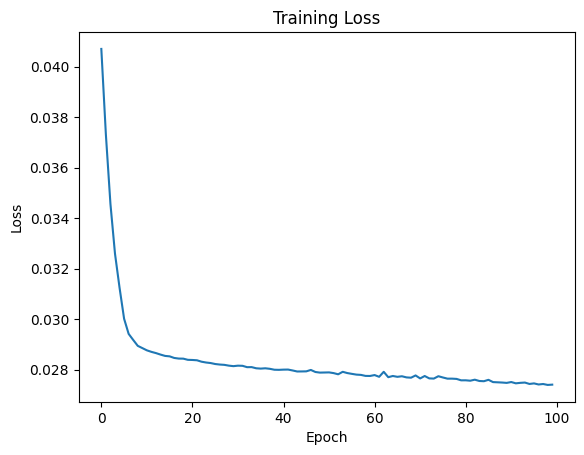

In [ ]:
# Plot the training loss curve
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [25]:
# make predictions
X_test = test_data[:, :-1]
y_test = test_data[:, -1]
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_pred = model.predict(X_test)

# evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f'LSTM MAE: {mae:.6f}')
print(f'LSTM MSE: {mse:.6f}')
print(f'LSTM RMSE: {rmse:.6f}')

1/1 [==============================] - 0s 321ms/step
LSTM MAE: 0.096897
LSTM MSE: 0.014249
LSTM RMSE: 0.119368


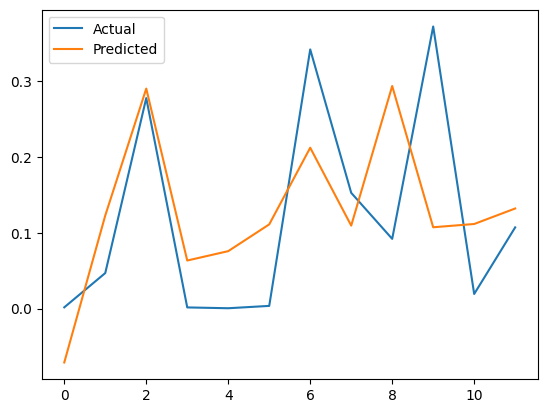

In [ ]:
# Visualize the results
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

### LSTM hyperparameter tuning

In [27]:
# Define the LSTM model
def create_model(units=50, activation='tanh', optimizer='adam'):
    model =Sequential()
    model.add(LSTM(units=units, activation=activation, 
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [28]:
# create the Keras wrapper for scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the hyperparameters to tune
param_grid = {
    'units': [50, 100],
    'activation': ['tanh', 'relu'],
    'optimizer': ['adam', 'sgd']
}

In [29]:
# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: nan using {'activation': 'tanh', 'optimizer': 'adam', 'units': 50}


In [30]:
# train the model with the best hyperparameters
model = create_model(units=50, activation='tanh', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# print the test set loss
print(f'Test set loss:, {mse:.6f}')

Epoch 1/50
5/5 [==============================] - 2s 3ms/step - loss: 0.0415
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0381
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0353
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0333
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0318
Epoch 6/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0305
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0296
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0290
Epoch 10/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0290
Epoch 11/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0290
Epoch 12/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 13/50
5/5 [==============================] - 0s 5ms/step - loss: 0.